<a href="https://colab.research.google.com/github/saadahmed388/projects/blob/main/detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tensorflow/models.git


Cloning into 'models'...
remote: Enumerating objects: 75342, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 75342 (delta 91), reused 161 (delta 81), pack-reused 75161
Receiving objects: 100% (75342/75342), 580.65 MiB | 29.98 MiB/s, done.
Resolving deltas: 100% (53432/53432), done.


In [ ]:
cd /content/models/research


/content/models/research


In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
import os
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils



 
PATH_TO_SAVED_MODEL = "/content/drive/MyDrive/training_demo/exported_models/my_model/saved_model" #Input the path where the model of detection and localization is

print('Loading model...', end='')
start_time = time.time()


detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

category_index = label_map_util.create_category_index_from_labelmap("/content/drive/MyDrive/training_demo/annotations/label_map.pbtxt",##Input the path of label_map.pbtxt
                                                                    use_display_name=True)

Loading model...WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
Done! Took 29.553425550460815 seconds


Running inference for /content/drive/MyDrive/training_demo/testing/toyo5.jpg... 

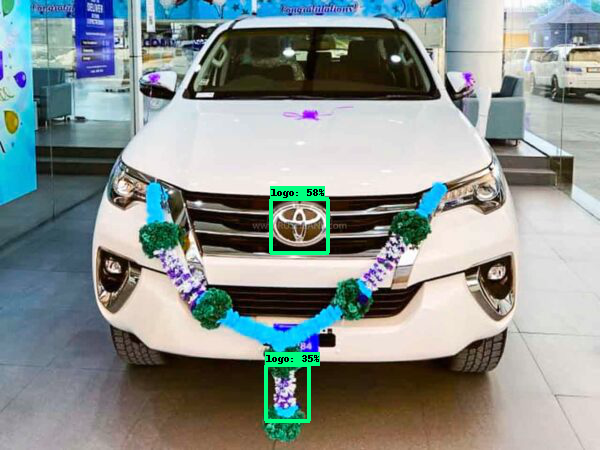

Done
58.18


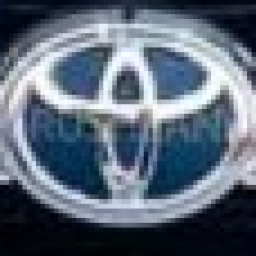

toyota
97.13
Running inference for /content/drive/MyDrive/training_demo/testing/mazda1.jpg... 

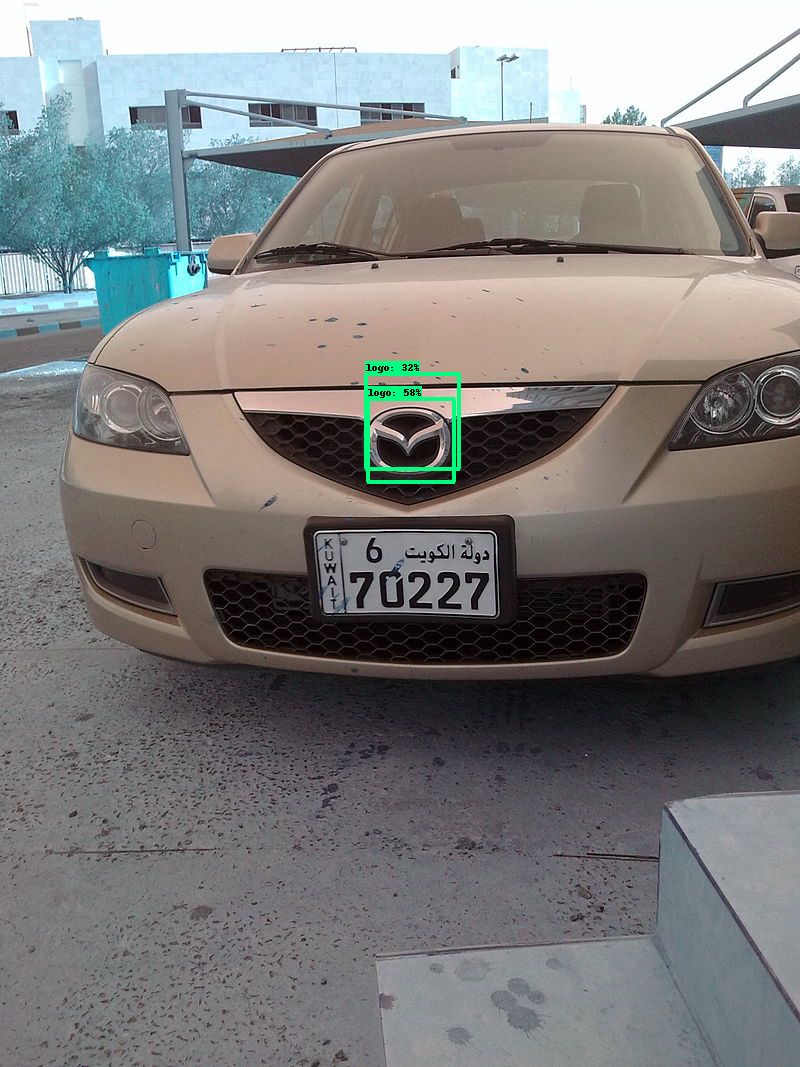

Done
57.98


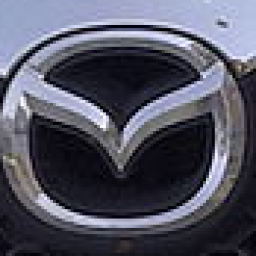

mazda
95.33


In [ ]:


import pathlib
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from google.colab.patches import cv2_imshow
import cv2

warnings.filterwarnings('ignore')   

def download_images():
    base_url = 'https://drive.google.com/file/d/1V5Jr5E-CXmWRszVfsUARjaSoeqDeblxX/view?usp=sharing/'
    filenames = ['toyo5.jpg','mazda1.jpg'] #input the nume of the filename on the model is to run

    image_paths = []
    for filename in filenames:
        image_path = '/content/drive/MyDrive/training_demo/testing/{}'.format(filename) #give the file path
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths


IMAGE_PATHS = download_images()



def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=2,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    cv2_imshow(image_np_with_detections)
    print('Done')
    plt.show()
    im_height, im_width, im_chan = image_np.shape

    ymin,xmin,ymax,xmax = detections['detection_boxes'][0]

    xmin*=im_width
    xmax*=im_width
    ymin*=im_height
    ymax*=im_height

    dim =(256,256)

    new_model = tf.keras.models.load_model('/content/drive/MyDrive/logo_scanning_model/model_1') # load the cnn model for logo brand prediction
    class_names = ['hyundai','lexus','mazda','mercedes','opel','skoda','toyota','volkswagen'] # due to lack of datasets , currently limited to  8 brands only
    img = cv2.imread(image_path)
    crop_img = img[round(ymin):round(ymax), round(xmin):round(xmax)]
    crop_img = crop_img.copy()
    resized = cv2.resize(crop_img, dim, interpolation = cv2.INTER_AREA)
    confidence = round((detections['detection_scores'][0]*100),2)
    print(confidence)
    cv2_imshow(resized)
    resized = np.expand_dims(resized,0)
    prediction = new_model.predict(resized)
    confidence = round((np.max(prediction)*100),2)
    print(class_names[np.argmax(prediction)])
    print(confidence)



    # sphinx_gallery_thumbnail_number = 2